# Integrate GEX and ATAC annotation and Trajectory analysis

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os

In [2]:
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
pd.options.display.max_columns=50

# Load ATAC and RNA

In [4]:
os.getcwd()

'/home/jovyan'

In [5]:
#os.chdir('/home/joyvan')

In [6]:
adata_atac = sc.read('project/proc_data/s2d1/donor1_atac.h5ad')
adata_rna = sc.read('project/proc_data/s2d1/donor1_gex.h5ad')

In [7]:
adata_rna

AnnData object with n_obs × n_vars = 4820 × 17431
    obs: 'sample', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_res0.5_msub3', 'leiden_res0.5_msub4', 'leiden_res0.5_bsub2', 'leiden_res0.5_epsub2', 'leiden_res0.5_5sub', 'leiden_res0.5_bsub3', 'leiden_res0.5_bsub4', 'leiden_res0.5_doubsub', 'leiden_intermediate1', 'leiden_intermediate2', 'leiden_intermediate3', 'leiden_intermediate4', 'leiden_final'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_5sub_colors', 'leiden_res0.5_bsub2_colors', 'leiden_res0.5_bsub3_colors', 'leiden_res0.5_bsub4_colors', 'leiden_res0.5_doubsub_colors', 'leiden_res0.5_epsub2_colors', 'leiden_res0.5_epsub_colors', 'leiden_res0.5_msub2_colors', 'leiden_res0.5_msub3_colors', 'leiden_res0.5_msub4_colors', 'leiden_res0.5_msub_colors', 'leiden_res0.5_tsub_colors', 'neighbors', 'pca', 'rg_res0.5_5sub', 'rg_res0.5_bsub2', 'rg_res0.5_bsub3', 'rg_res0.5_bsub4', 

In [8]:
adata_atac

AnnData object with n_obs × n_vars = 5454 × 19039
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final'
    uns: 'neighbors', 'peak_names'
    obsm: 'lsi_full', 'lsi_red', 'peaks', 'umap'
    obsp: 'connectivities', 'distances'

# Merge datasets

Note on doublets: We filtered out doublet in the GEX processing. In ATAC data, doublet removal seems to be less successful. Therefore, we rely on the doublet detection in the GEX data and remove them by getting the cells shared between both data sets.

In [9]:
adata_rna.obs_names

Index(['AAACATGCAACAGGTG-4', 'AAACATGCAGTCTAAT-4', 'AAACATGCAGTCTAGC-4',
       'AAACATGCATAGCTGC-4', 'AAACATGCATTAGCCA-4', 'AAACCGAAGGATCCGC-4',
       'AAACCGAAGGTCATTA-4', 'AAACCGCGTAACGAGG-4', 'AAACCGCGTACCGAAC-4',
       'AAACCGGCAGCAACCT-4',
       ...
       'TTTGTGAAGCAAGGAC-4', 'TTTGTGAAGTGAGCAA-4', 'TTTGTGAAGTTCCTGC-4',
       'TTTGTGAAGTTTAACG-4', 'TTTGTGGCAGCTACGT-4', 'TTTGTGTTCAGCACGC-4',
       'TTTGTGTTCGTTATAG-4', 'TTTGTTGGTCCACAAA-4', 'TTTGTTGGTGAGGTAG-4',
       'TTTGTTGGTTTGGGTA-4'],
      dtype='object', length=4820)

In [10]:
adata_atac.obs_names

Index(['AAACAGCCATCCCGCT-1', 'AAACATGCAACAGGTG-1', 'AAACATGCAGTCTAAT-1',
       'AAACATGCAGTCTAGC-1', 'AAACATGCATAGCTGC-1', 'AAACATGCATTAGCCA-1',
       'AAACCAACAACCCTCC-1', 'AAACCAACACATAGCC-1', 'AAACCGAAGGATCCGC-1',
       'AAACCGAAGGCATTAC-1',
       ...
       'TTTGTGAAGTGAGCAA-1', 'TTTGTGAAGTTCCTGC-1', 'TTTGTGAAGTTTAACG-1',
       'TTTGTGGCAATTGCGC-1', 'TTTGTGGCAGCTACGT-1', 'TTTGTGTTCAGCACGC-1',
       'TTTGTGTTCGTTATAG-1', 'TTTGTTGGTCCACAAA-1', 'TTTGTTGGTGAGGTAG-1',
       'TTTGTTGGTTTGGGTA-1'],
      dtype='object', length=5454)

In [11]:
# corrects adata_atac barcodes to end with -4 
adata_atac.obs['corrected_barcodes'] = [name.replace('-1','-4') for name in adata_atac.obs_names.values]

In [12]:
adata_atac.obs_names = adata_atac.obs['corrected_barcodes']

In [13]:
# select the subset of the cells that belong to both RNA and ATAC data
common_barcodes = list(set(adata_rna.obs_names).intersection(adata_atac.obs_names))
adata_rna_sub = adata_rna[common_barcodes].copy()
adata_atac_sub = adata_atac[common_barcodes].copy()

In [14]:
adata_rna_sub.obs['atac_ann'] = adata_atac_sub.obs['leiden_final']
adata_atac_sub.obs['rna_ann'] = adata_rna_sub.obs['leiden_final']

# Merge leiden_finals

Here, we plot the celltype annotation based on the two modalities on the UMAP representation of each. Thereby we can assess how well the annotation of one modality matches the data structure in the other modality. This gives us a first overview where one modality contains additional substructure compared to the other.

For each celltype, we try to find the modality the represents a cleaner and more fine grained clustering. E.g. for T cells, the clusters are better separated in the ATAC data (CD4+ vs CD8+), while for B cells additional substructure is found in the GEX data (see how the Transitional B cell cluster from ATAC is sparated into two distant clusters in the GEX data).

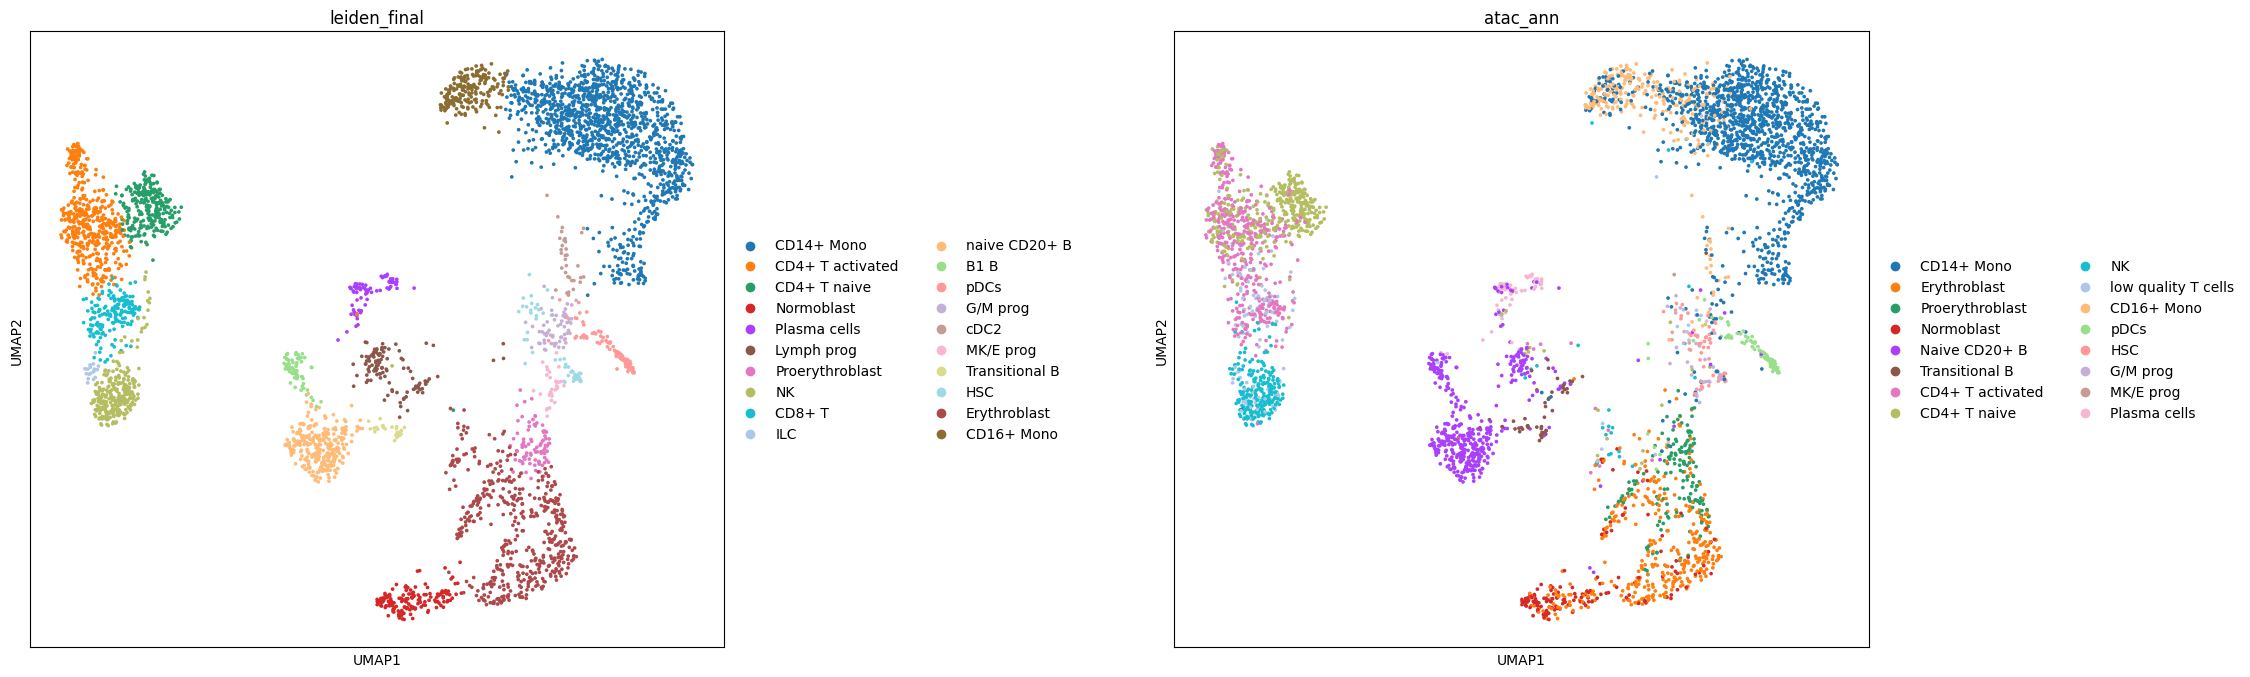

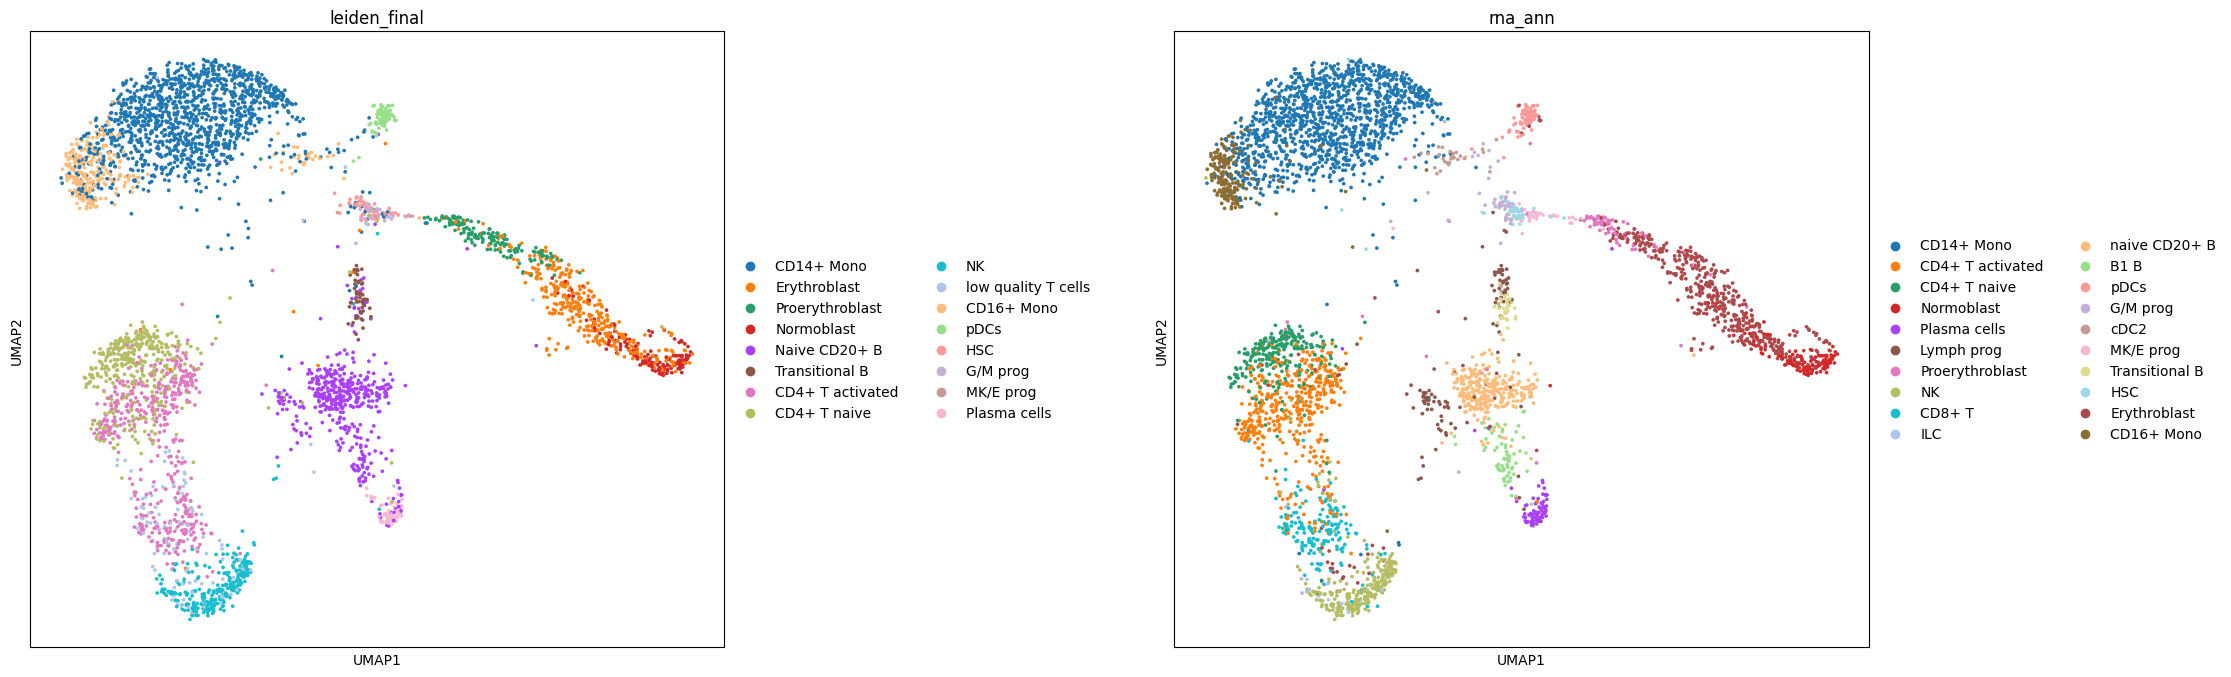

In [15]:
sc.pl.umap(adata_rna_sub, color=['leiden_final', 'atac_ann'], wspace=0.5)
sc.pl.umap(adata_atac_sub, color=['leiden_final', 'rna_ann'], wspace=0.5)

We then decide which modality should be the more determining one for each cell type:

- ILC cells better in RNA
- HSC better in RNA
- cDC2 better in RNA
- Progenitors better in RNA
- Lymph prog better in RNA
- transitional B better in RNA
- Monocytes better in RNA (except ID2-myeloid prog)
- Erythrocytes/Normoblast better in RNA
- T cells better in RNA
- B cell better in RNA
- pDCs better in RNA
- NK cells better in ATAC



## Crosstab leiden_finals

We now dive into details and check which cell type in one modality corresponds to the celltype in the second.

We look for differing annotations and check those with marker genes for each modality below. Thereby, we take a final decision for each celltype, which annotation we will use.

In [16]:
# Note: First argument corresponds to rows (here, RNA), second argument to columns (here: ATAC)
pd.crosstab(adata_rna_sub.obs['leiden_final'], adata_atac_sub.obs['leiden_final'])

leiden_final      CD14+ Mono  Erythroblast  Proerythroblast  Normoblast  \
leiden_final                                                              
CD14+ Mono              1191             0                0           0   
CD4+ T activated           0             0                0           0   
CD4+ T naive               0             0                0           0   
Normoblast                 0            52                0          93   
Plasma cells               0             0                0           0   
Lymph prog                 3             1                0           0   
Proerythroblast            4            16               59           0   
NK                         1             0                0           0   
CD8+ T                     0             0                0           0   
ILC                        0             0                0           0   
naive CD20+ B              1             1                0           0   
B1 B                       0             0                0           0   
pDCs                       6             0                0           0   
G/M prog                  11             0                0           0   
cDC2                      14             0                0           0   
MK/E prog                  6             1                4           0   
Transitional B             0             0                0           0   
HSC                        8             0                0           0   
Erythroblast               0           291               95          54   
CD16+ Mono                65             0                0           0   

leiden_final      Naive CD20+ B  Transitional B  CD4+ T activated  \
leiden_final                                                        
CD14+ Mono                    0               0                 1   
CD4+ T activated              0               0               275   
CD4+ T naive                  0               0                38   
Normoblast                    1               0                 0   
Plasma cells                 21               0                 0   
Lymph prog                   64              22                 5   
Proerythroblast               2               0                 0   
NK                            0               0                12   
CD8+ T                        0               0               113   
ILC                           0               0                 0   
naive CD20+ B               284               3                 0   
B1 B                         64               0                 0   
pDCs                          2               0                 0   
G/M prog                      1               0                 0   
cDC2                          1               1                 0   
MK/E prog                     0               0                 0   
Transitional B                4              27                 0   
HSC                           1               0                 0   
Erythroblast                  3               0                 5   
CD16+ Mono                    0               0                 0   

leiden_final      CD4+ T naive   NK  low quality T cells  CD16+ Mono  pDCs  \
leiden_final                                                                 
CD14+ Mono                   0    4                    3         109     0   
CD4+ T activated           150    0                   21           0     0   
CD4+ T naive               214    0                    2           0     0   
Normoblast                   0    0                    0           0     0   
Plasma cells                 1    0                    2           0     0   
Lymph prog                   6    4                    1           0     2   
Proerythroblast              2    0                    0           0     0   
NK                           2  211                   43           0     0   
CD8+ T                       1   15               

### Load marker genes

In case in your analysis other markers showed up, we can add them here as well

In [17]:
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
    'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'],
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],
    'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
    'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'RF4', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'],
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'],
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1'] # Note PLCB1 is a negative marker
}

#ATAC
marker_genes_atac = {
    'CD14+ Mono': ['TREM1', 'FPR1'],
    'CD16+ Mono': ['LYN', 'TCF7L2'],
    'ID2-hi myeloid prog': ['KLF4'],
    'cDC2': ['TREM1', 'DMXL2'], # Note: DMXL2 should be negative
    'Normoblast': ['GATA1', 'HBA1', 'SLC4A1', 'SLC25A37', 'KLF1'],
    'Erythroblast': ['GATA1', 'MKI67'],
    'Proerythroblast': ['GATA2', 'CRACD', 'SYNGR1'],
    'NK': ['CD160', 'GNLY', 'GRIK4', 'CD247'],
    'ILC': ['SPON2', 'GZMB', 'PRF1', 'C69'], # Note CD69 should be negative
    'Lymph prog': ['MME', 'IGLL1', 'VPREB1', 'CD79B'],
    'Naive CD20+ B': ['MS4A1', 'LYN', 'CD74', 'BLK'],
    'B1 B': ['ITGB1', 'MS4A1', 'DUSP22', 'EPHA4'],
    'Transitional B': ['MME', 'CD38', 'CD24'],
    'Plasma cells': ['DUSP22', 'FNDC3B'],
    'CD4+ T activated': ['JAKMIP1', 'C4orf50'],
    'CD4+ T naive': [ 'BCL11B', 'BACH2', 'JAKMIP1', 'C4orf50'], # Note JAKMIP1 and C4orf50 are negative markers
    'CD8+ T': ['CD8A', 'CD8B'],
    'pDCs': ['PTPRS', 'TCF4', 'KCNN3', 'DUSP22'],
    'G/M prog': ['MPO','NT5DC3'],
    'HSC': ['PRDM16','TAMALIN','MTRNR2L1'],
    'MK/E prog': ['DNAJC6']
}


**Which annotation to be used per celltype**

(Plotting specific marker genes for clarification below)

From RNA:
- ILC
- cDC2
- Lymph prog
- HSC
- Transitional B
- CD14+ Mono
- CD16+ Mono
- CD4+ T activated
- CD4+ T naive
- CD8+ T
- naive CD20+ B
- B1 B
- pDCs
- G/M prog
- MK/E prog
- Plasma cells
- Normoblast
- Erythroblast
- Proerythroblast

From ATAC:
- NK
- ID2-hi myeloid prog

Notes:

### Check out specific celltypes

Check out cell type markers in each modality to see which clusters are more disctinct. Here we plot RNA and ATAC markers on both representations.

Markers on RNA


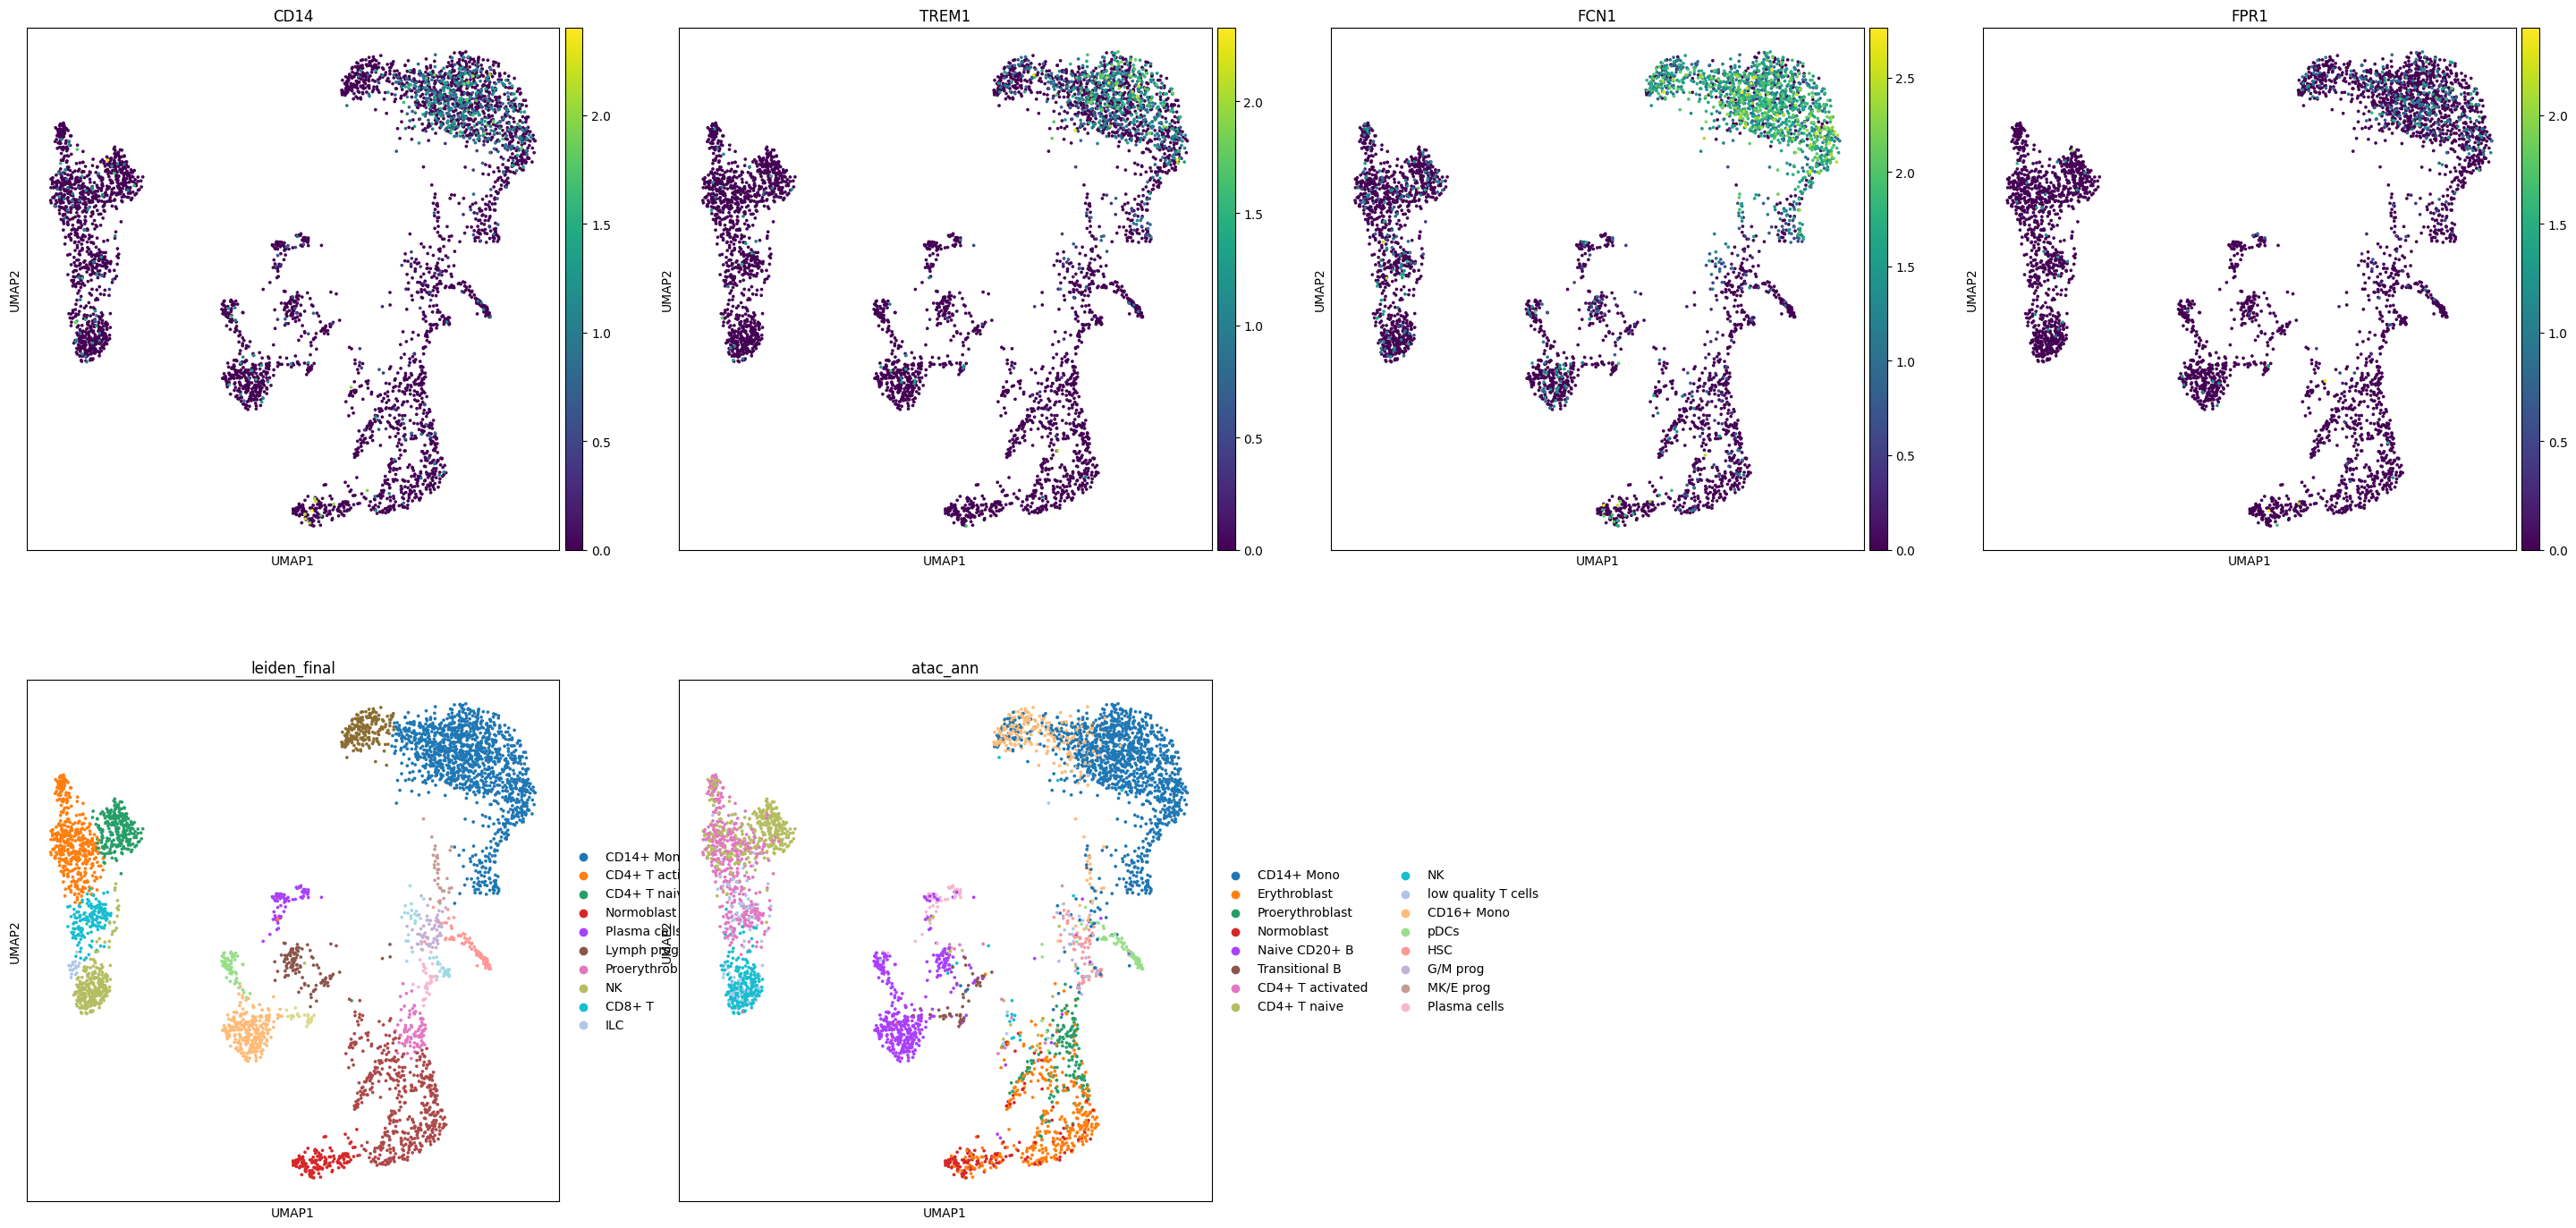

Markers on ATAC


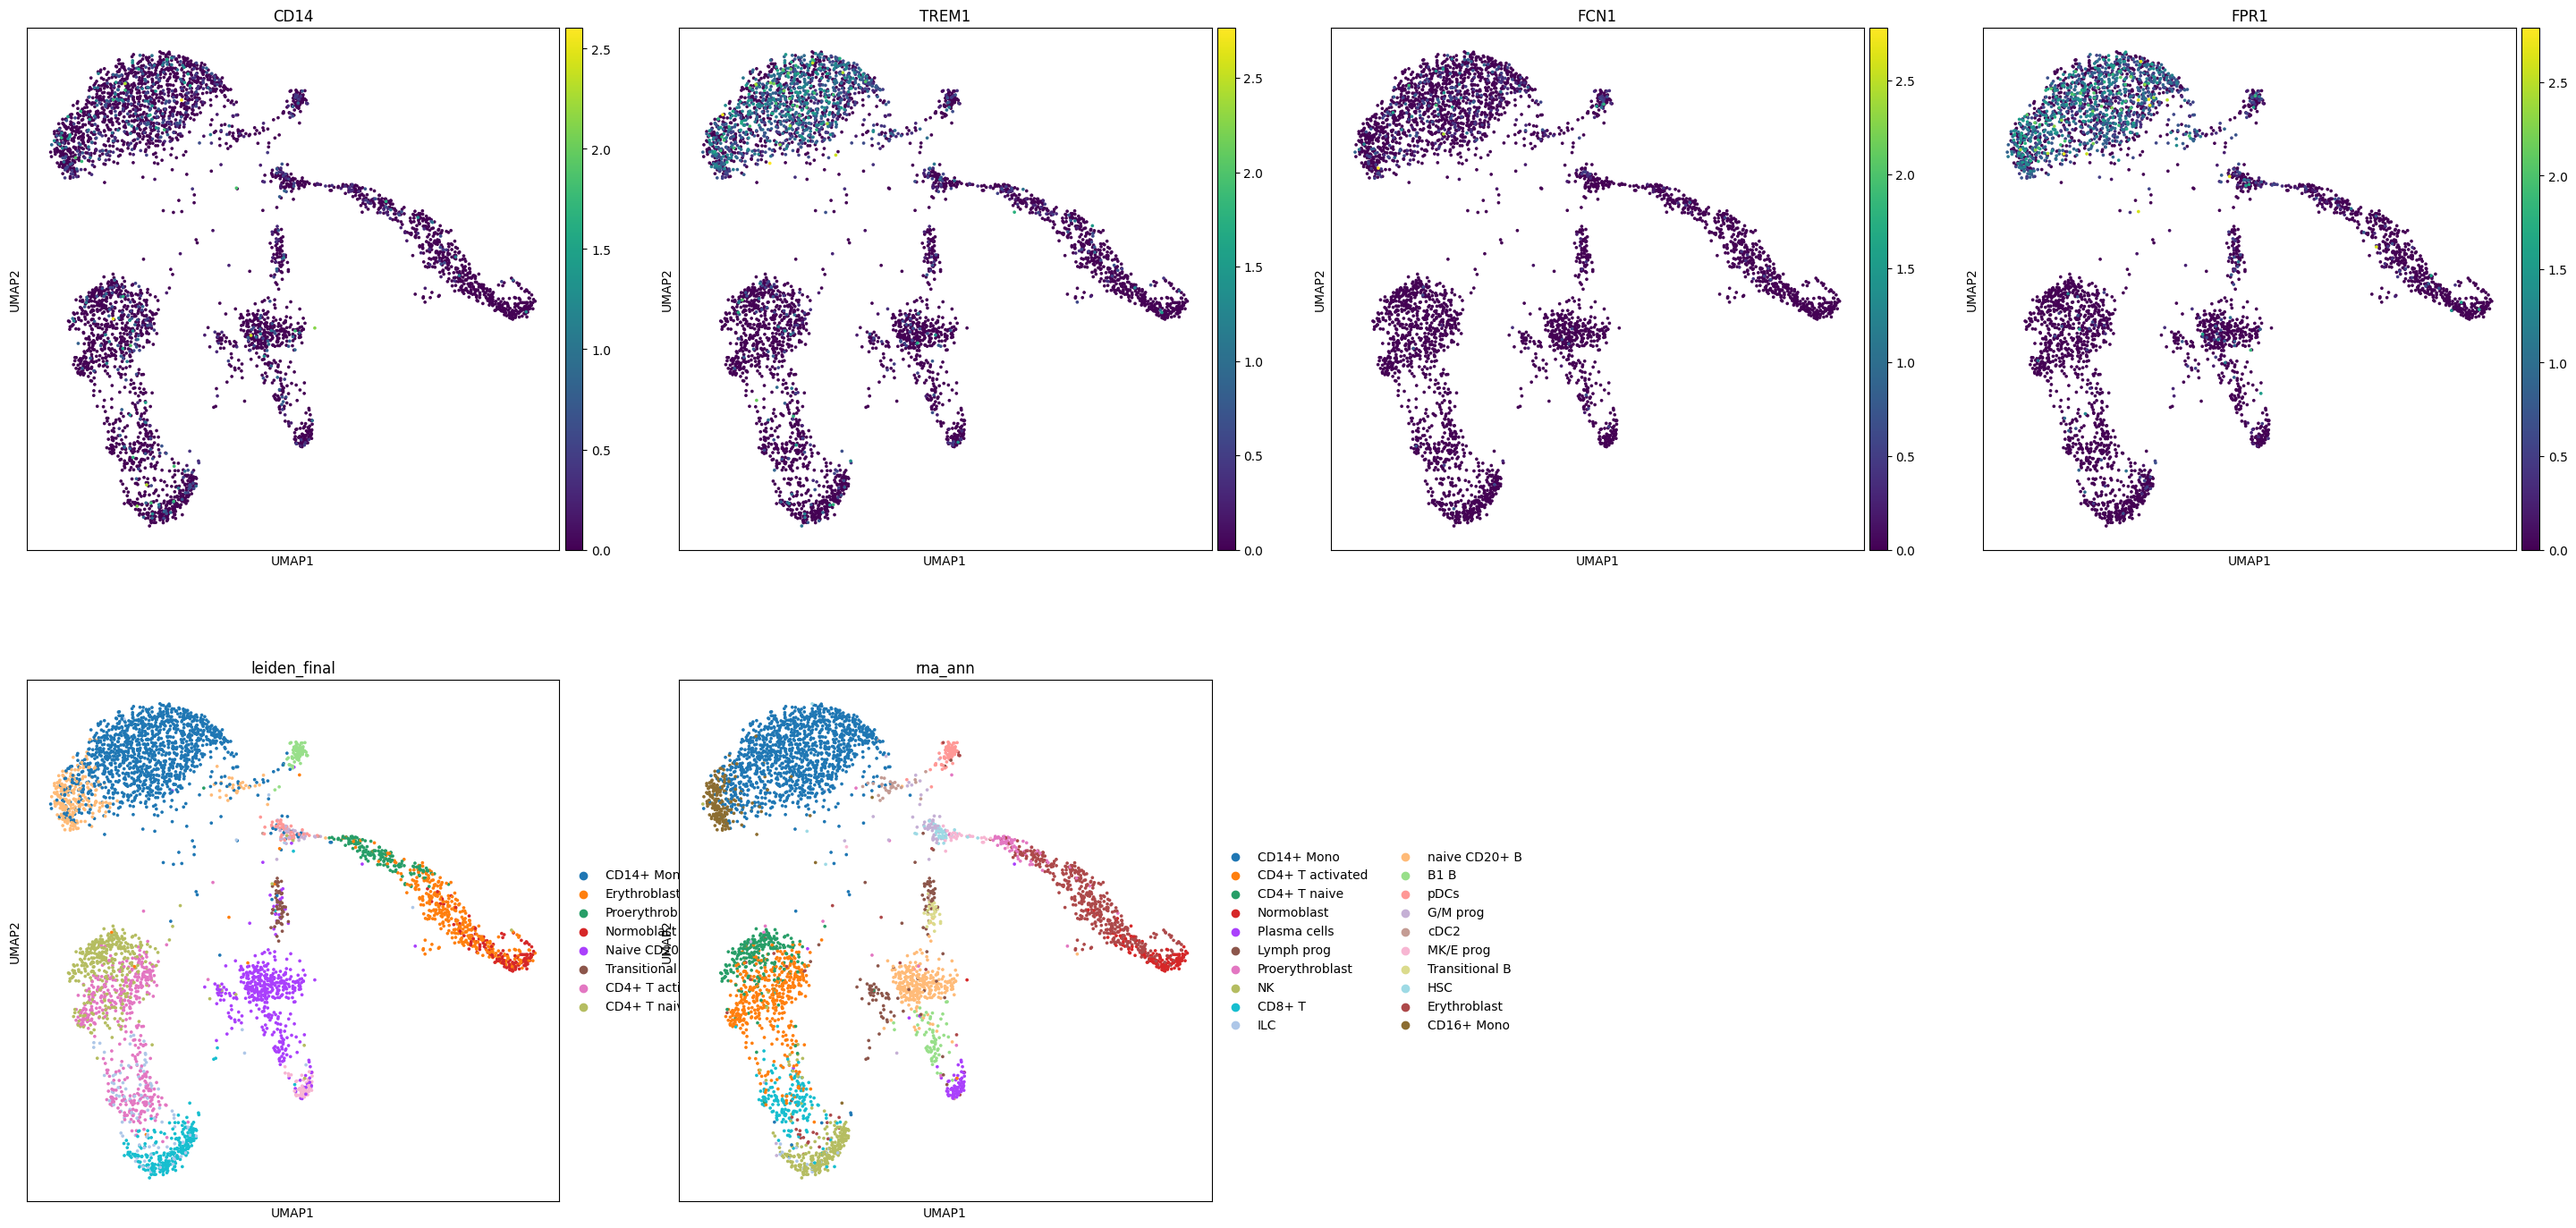

In [18]:
# select celltypes to compare
rna_ct = 'CD14+ Mono'
atac_ct = 'CD14+ Mono'

genes = marker_genes_rna[rna_ct]+marker_genes_atac[atac_ct]
ann_key_r = 'leiden_final'
ann_key_a = 'leiden_final'

genes_r = [g for g in adata_rna_sub.var_names if str(g) in genes ]
genes_a = [g for g in adata_atac_sub.var_names if str(g) in genes]

print('Markers on RNA')
sc.pl.umap(adata_rna_sub, color=genes_r+[ann_key_r, 'atac_ann'])

print('Markers on ATAC')
sc.pl.umap(adata_atac_sub, color=genes_a+[ann_key_a, 'rna_ann'])

if len(genes) < 3:
    plt.rcParams['figure.figsize'] = (24,8)
    sc.pl.violin(adata_atac_sub, keys=genes_a, groupby=ann_key_a)
    plt.rcParams['figure.figsize'] = (8,8)

Additional highlighting of selected clusters (e.g. in case you can't identify particular clusters from the ATAC or RNA plots due to bad coloring)

... storing 'test' as categorical


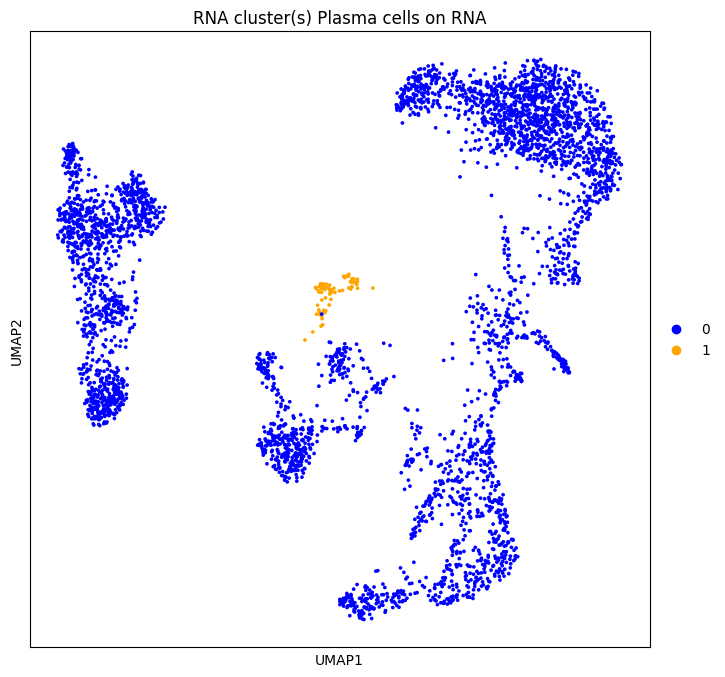

... storing 'test' as categorical


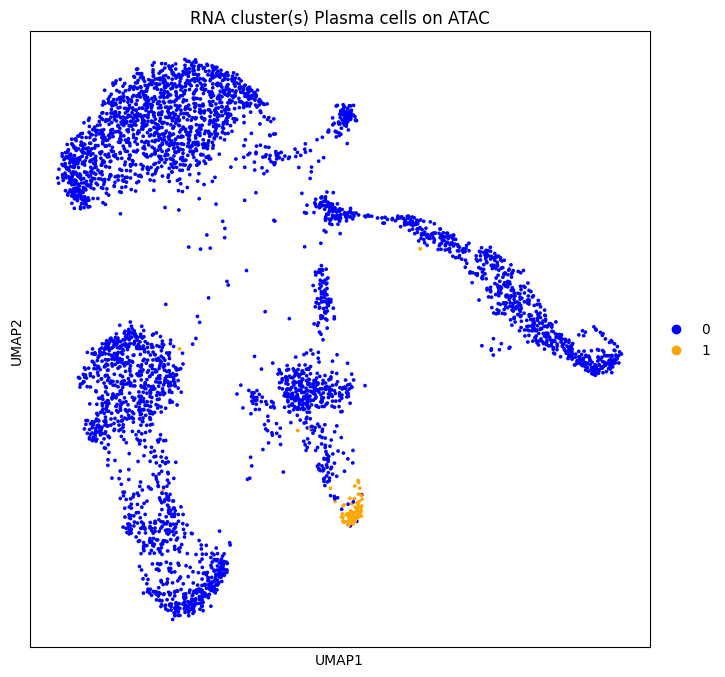

... storing 'test' as categorical


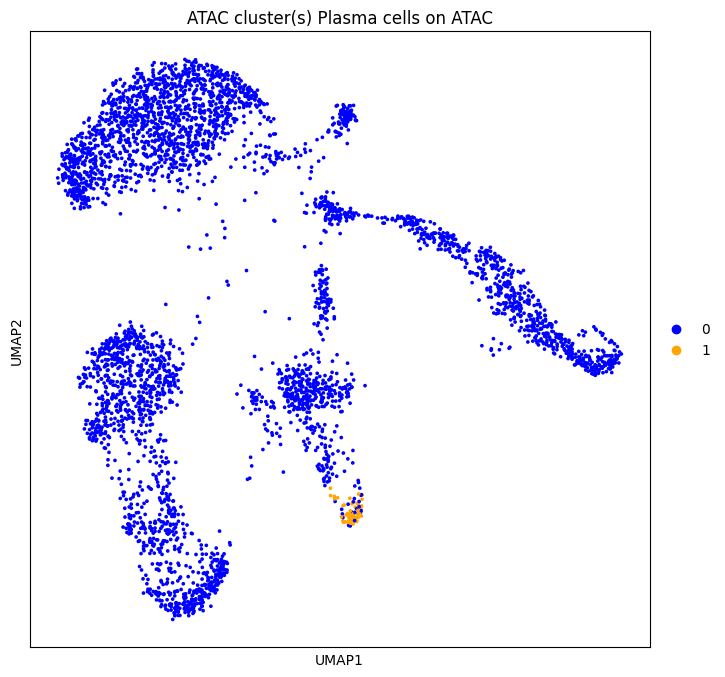

... storing 'test' as categorical


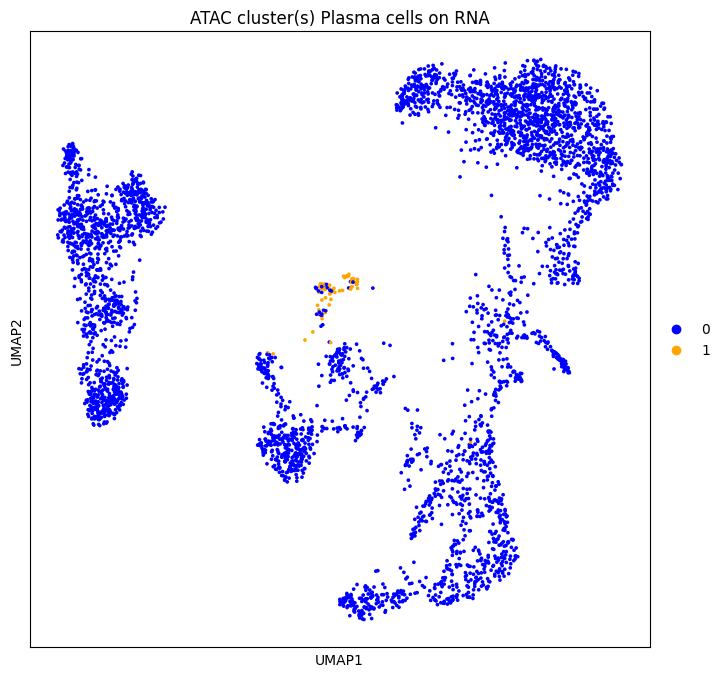

In [19]:
#RNA clusters
#-------------
# Use celltype from above
#clusts = [rna_ct]
# Or selct new ones
clusts = ['Plasma cells']

adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['leiden_final']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on RNA')
adata_atac_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_atac_sub.obs['rna_ann']]
sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on ATAC')


#ATAC clusters
#--------------
# Use celltype from above
clusts = [atac_ct]
# Or selct new ones
clusts = ['Plasma cells']

adata_atac_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_atac_sub.obs['leiden_final']]
sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'ATAC cluster(s) '+ '; '.join(clusts) + ' on ATAC')
adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['atac_ann']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'ATAC cluster(s) '+ '; '.join(clusts) + ' on RNA')



In [20]:
adata_rna_sub.obs['leiden_final'].cat.categories

Index(['CD14+ Mono', 'CD4+ T activated', 'CD4+ T naive', 'Normoblast',
       'Plasma cells', 'Lymph prog', 'Proerythroblast', 'NK', 'CD8+ T', 'ILC',
       'naive CD20+ B', 'B1 B', 'pDCs', 'G/M prog', 'cDC2', 'MK/E prog',
       'Transitional B', 'HSC', 'Erythroblast', 'CD16+ Mono'],
      dtype='object')

In [21]:
adata_atac_sub.obs['leiden_final'].cat.categories

Index(['CD14+ Mono', 'Erythroblast', 'Proerythroblast', 'Normoblast',
       'Naive CD20+ B', 'Transitional B', 'CD4+ T activated', 'CD4+ T naive',
       'NK', 'low quality T cells', 'CD16+ Mono', 'pDCs', 'HSC', 'G/M prog',
       'MK/E prog', 'Plasma cells'],
      dtype='object')

## Create a final merged celltype annotation

In [22]:
# List RNA celltypes
set(adata_rna_sub.obs['leiden_final'])

{'B1 B',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T',
 'Erythroblast',
 'G/M prog',
 'HSC',
 'ILC',
 'Lymph prog',
 'MK/E prog',
 'NK',
 'Normoblast',
 'Plasma cells',
 'Proerythroblast',
 'Transitional B',
 'cDC2',
 'naive CD20+ B',
 'pDCs'}

In [23]:
# List ATAC celltypes
set(adata_atac_sub.obs['leiden_final'])

{'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T naive',
 'Erythroblast',
 'G/M prog',
 'HSC',
 'MK/E prog',
 'NK',
 'Naive CD20+ B',
 'Normoblast',
 'Plasma cells',
 'Proerythroblast',
 'Transitional B',
 'low quality T cells',
 'pDCs'}

**Which annotation to be used per celltype**

(Checked using the pairwise comparison of UMAP projection above)

From RNA:
- ILC
- Lymph prog
- HSC
- Transitional B
- CD14+ Mono
- CD16+ Mono
- CD4+ T activated
- CD4+ T naive
- CD8+ T
- naive CD20+ B
- B1 B
- pDCs
- G/M prog
- MK/E prog
- Plasma cells
- Normoblast
- Erythroblast
- Proerythroblastc

From ATAC:
- ID2-hi myeloid prog
- NK
- cDC2

Notes:

In [24]:
# Chose celltype from each modality:

# The order should be 'rna_cts':'atac_cts'
celltype_map_rna = {
    'ILC':'ILC',
    'HSC':'HSC',
    'Transitional B':'Transitional B',
    'Lymph prog':'Lymph prog',
    'CD14+ Mono':'CD14+ Mono',
    'CD16+ Mono':'CD16+ Mono',
    'CD4+ T activated':'CD4+ T activated',
    'CD4+ T naive':'CD4+ T naive',
    'CD8+ T':'CD8+ T',    
    'naive CD20+ B':'Naive CD20+ B',
    'Normoblast':'Normoblast',
    'Erythroblast':'Erythroblast',
    'Proerythroblast':'Proerythroblast',
    'pDCs':'pDCs',
    'G/M prog':'G/M prog',
    'MK/E prog':'MK/E prog',
    'B1 B': 'B1 B',
    'NK':'NK',
    'Plasma cells':'Plasma cells'
}

# The order should be 'atac_cts':'rna_cts'
celltype_map_atac = {
    'ID2-hi myeloid prog':'ID2-hi myeloid prog',
    'cDC2':'cDC2'

}

rna_cts = list(celltype_map_rna.keys())
atac_cts = list(celltype_map_atac.keys())

Create new colomn with selected celltypes and add **'Oh god'** for cells that are not part of one of the selected celltype clusters:

In [25]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    atac_ct = adata_atac_sub.obs['leiden_final'][idx]
    
    if atac_ct in atac_cts:
        new_celltype_ann.append(celltype_map_atac[atac_ct])
    elif rna_ct in rna_cts:
        new_celltype_ann.append(celltype_map_rna[rna_ct])
    else:
        new_celltype_ann.append('Oh god')

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_atac_sub.obs['celltype'] = final_ann_df

In [26]:
# Number of cells per celltype
adata_rna_sub.obs['celltype'].value_counts()

CD14+ Mono          1308
Erythroblast         478
CD4+ T activated     446
Naive CD20+ B        289
NK                   269
CD4+ T naive         254
CD16+ Mono           209
CD8+ T               169
Normoblast           146
Lymph prog           109
pDCs                  89
Proerythroblast       85
Plasma cells          76
B1 B                  67
G/M prog              60
HSC                   50
Oh god                34
MK/E prog             33
Transitional B        31
ILC                   18
Name: celltype, dtype: int64

Now we need to take a closer look at the **'Oh god'** cells.

We do so by checking the celltypes per modality, **'Oh god'** cells come from:

In [27]:
# Comparison of final celltypes with RNA celltypes
pd.crosstab(adata_rna_sub.obs['celltype'], adata_rna_sub.obs['leiden_final'])

leiden_final      CD14+ Mono  CD4+ T activated  CD4+ T naive  Normoblast  \
celltype                                                                   
B1 B                       0                 0             0           0   
CD14+ Mono              1308                 0             0           0   
CD16+ Mono                 0                 0             0           0   
CD4+ T activated           0               446             0           0   
CD4+ T naive               0                 0           254           0   
CD8+ T                     0                 0             0           0   
Erythroblast               0                 0             0           0   
G/M prog                   0                 0             0           0   
HSC                        0                 0             0           0   
ILC                        0                 0             0           0   
Lymph prog                 0                 0             0           0   
MK/E prog                  0                 0             0           0   
NK                         0                 0             0           0   
Naive CD20+ B              0                 0             0           0   
Normoblast                 0                 0             0         146   
Oh god                     0                 0             0           0   
Plasma cells               0                 0             0           0   
Proerythroblast            0                 0             0           0   
Transitional B             0                 0             0           0   
pDCs                       0                 0             0           0   

leiden_final      Plasma cells  Lymph prog  Proerythroblast   NK  CD8+ T  ILC  \
celltype                                                                        
B1 B                         0           0                0    0       0    0   
CD14+ Mono                   0           0                0    0       0    0   
CD16+ Mono                   0           0                0    0       0    0   
CD4+ T activated             0           0                0    0       0    0   
CD4+ T naive                 0           0                0    0       0    0   
CD8+ T                       0           0                0    0     169    0   
Erythroblast                 0           0                0    0       0    0   
G/M prog                     0           0                0    0       0    0   
HSC                          0           0                0    0       0    0   
ILC                          0           0                0    0       0   18   
Lymph prog                   0         109                0    0       0    0   
MK/E prog                    0           0                0    0       0    0   
NK                           0           0                0  269       0    0   
Naive CD20+ B                0           0                0    0       0    0   
Normoblast                   0           0                0    0       0    0   
Oh god                       0           0                0    0       0    0   
Plasma cells                76           0                0    0       0    0   
Proerythroblast              0           0               85    0       0    0   
Transitional B               0           0                0    0       0    0   
pDCs                         0           0                0    0       0    0   

leiden_final      naive CD20+ B  B1 B  pDCs  G/M prog  cDC2  MK/E prog  \
celltype                                                                 
B1 B                          0    67     0         0     0          0   
CD14+ Mono                    0     0     0         0     0          0   
CD16+ Mono                    0     0     0         0     0          0   
CD4+ T activated              0     0     0         0     0          0   
CD4+ T naive                  0     0     0         0     0          0   
CD8+ T                    

In [28]:
# Comparison of final celltypes with ATAC celltypes
pd.crosstab(adata_atac_sub.obs['celltype'], adata_atac_sub.obs['leiden_final'])

leiden_final      CD14+ Mono  Erythroblast  Proerythroblast  Normoblast  \
celltype                                                                  
B1 B                       0             0                0           0   
CD14+ Mono              1191             0                0           0   
CD16+ Mono                65             0                0           0   
CD4+ T activated           0             0                0           0   
CD4+ T naive               0             0                0           0   
CD8+ T                     0             0                0           0   
Erythroblast               0           291               95          54   
G/M prog                  11             0                0           0   
HSC                        8             0                0           0   
ILC                        0             0                0           0   
Lymph prog                 3             1                0           0   
MK/E prog                  6             1                4           0   
NK                         1             0                0           0   
Naive CD20+ B              1             1                0           0   
Normoblast                 0            52                0          93   
Oh god                    14             0                0           0   
Plasma cells               0             0                0           0   
Proerythroblast            4            16               59           0   
Transitional B             0             0                0           0   
pDCs                       6             0                0           0   

leiden_final      Naive CD20+ B  Transitional B  CD4+ T activated  \
celltype                                                            
B1 B                         64               0                 0   
CD14+ Mono                    0               0                 1   
CD16+ Mono                    0               0                 0   
CD4+ T activated              0               0               275   
CD4+ T naive                  0               0                38   
CD8+ T                        0               0               113   
Erythroblast                  3               0                 5   
G/M prog                      1               0                 0   
HSC                           1               0                 0   
ILC                           0               0                 0   
Lymph prog                   64              22                 5   
MK/E prog                     0               0                 0   
NK                            0               0                12   
Naive CD20+ B               284               3                 0   
Normoblast                    1               0                 0   
Oh god                        1               1                 0   
Plasma cells                 21               0                 0   
Proerythroblast               2               0                 0   
Transitional B                4              27                 0   
pDCs                          2               0                 0   

leiden_final      CD4+ T naive   NK  low quality T cells  CD16+ Mono  pDCs  \
celltype                                                                     
B1 B                         0    0                    1           0     0   
CD14+ Mono                   0    4                    3         109     0   
CD16+ Mono                   0    1                    0         143     0   
CD4+ T activated           150    0                   21           0     0   
CD4+ T naive               214    0                    2           0     0   
CD8+ T                       1   15                   40           0     0   
Erythroblast                 7   13                    4           0     5   
G/M prog                     1    2                    6           4     2   
HSC                          1    0               

### Resolve unannotated cells

This includes
- Remaining clusters that were not included in final annotation at all (e.g. high count - T doublet from ATAC, which we assign to CD4+ T naive (also given the RNA annotation)
- Subsets of clusters that were not defined in the final celltypes. It is helpful to check again where the unassigned cells might come from. Depending on whether an association with a certain celltype can be made, they should be labeled accordingly or be removed.

In [29]:
adata_rna_sub

AnnData object with n_obs × n_vars = 4220 × 17431
    obs: 'sample', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_res0.5_msub3', 'leiden_res0.5_msub4', 'leiden_res0.5_bsub2', 'leiden_res0.5_epsub2', 'leiden_res0.5_5sub', 'leiden_res0.5_bsub3', 'leiden_res0.5_bsub4', 'leiden_res0.5_doubsub', 'leiden_intermediate1', 'leiden_intermediate2', 'leiden_intermediate3', 'leiden_intermediate4', 'leiden_final', 'atac_ann', 'test', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_5sub_colors', 'leiden_res0.5_bsub2_colors', 'leiden_res0.5_bsub3_colors', 'leiden_res0.5_bsub4_colors', 'leiden_res0.5_doubsub_colors', 'leiden_res0.5_epsub2_colors', 'leiden_res0.5_epsub_colors', 'leiden_res0.5_msub2_colors', 'leiden_res0.5_msub3_colors', 'leiden_res0.5_msub4_colors', 'leiden_res0.5_msub_colors', 'leiden_res0.5_tsub_colors', 'neighbors', 'pca', 'rg_res0.5_5sub', 'rg_res0.5_bsub2', 'rg_re

In [30]:
adata_atac_sub

AnnData object with n_obs × n_vars = 4220 × 19039
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype'
    uns: 'neighbors', 'peak_names', 'leiden_final_colors', 'rna_ann_colors', 'test_colors'
    obsm: 'lsi_full', 'lsi_red', 'peaks', 'umap'
    obsp: 'connectivities', 'distances'

In [31]:
# Plot specific 'Oh god' cells

# in RNA
#clust = ['low quality T cells']
rna_clust = ['naive CD20+ B']

test_vec_rna = []

for i,ct in enumerate(adata_rna_sub.obs['leiden_final']):
    
    if ct in rna_clust:
        if adata_rna_sub.obs['celltype'][i]=='Oh god':
            test_vec_rna.append('1')
        else:
            test_vec_rna.append('0')
    else:
        test_vec_rna.append('0')

# in ATAC
atac_clust = ['Naive CD20+ B']
test_vec_atac = []

for i,ct in enumerate(adata_atac_sub.obs['leiden_final']):
    
    if ct in atac_clust:
        if adata_atac_sub.obs['celltype'][i]=='Oh god':
            test_vec_atac.append('1')
        else:
            test_vec_atac.append('0')
    else:
        test_vec_atac.append('0')

... storing 'test' as categorical
... storing 'celltype' as categorical


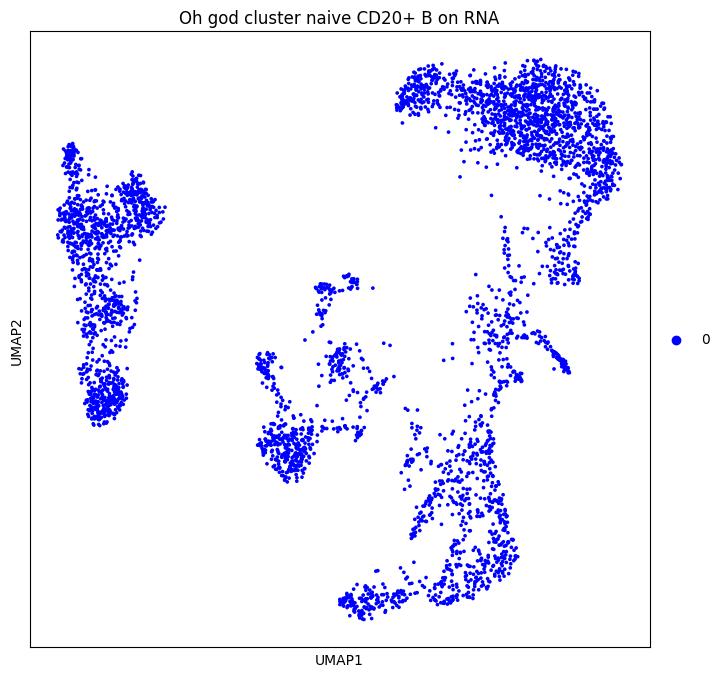

... storing 'test' as categorical
... storing 'celltype' as categorical


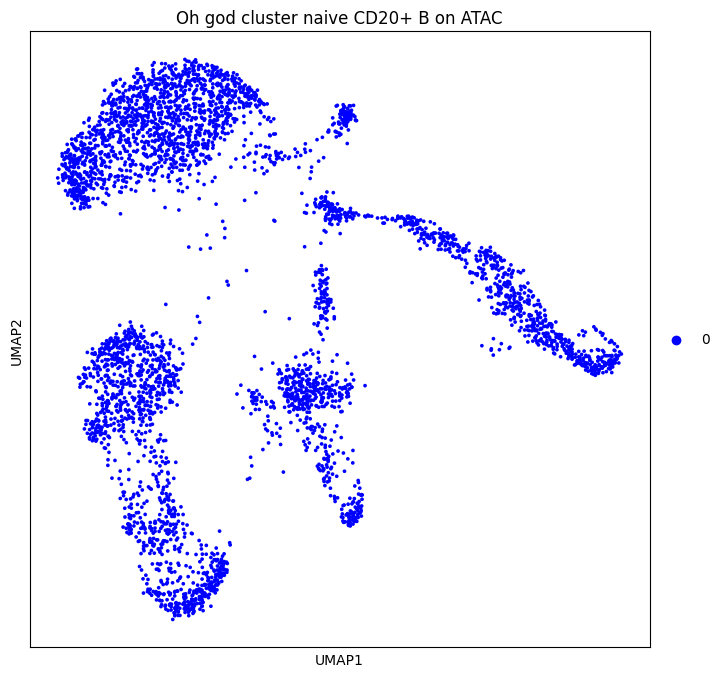

In [32]:
adata_rna_sub.obs['test'] = test_vec_rna
adata_atac_sub.obs['test'] = test_vec_rna

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ rna_clust[0] + ' on RNA')

sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ rna_clust[0] + ' on ATAC')

... storing 'test' as categorical


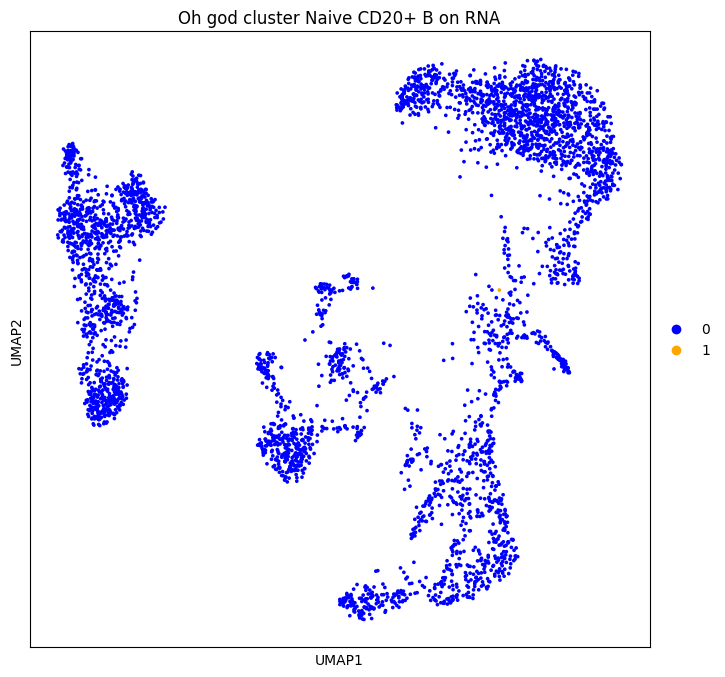

... storing 'test' as categorical


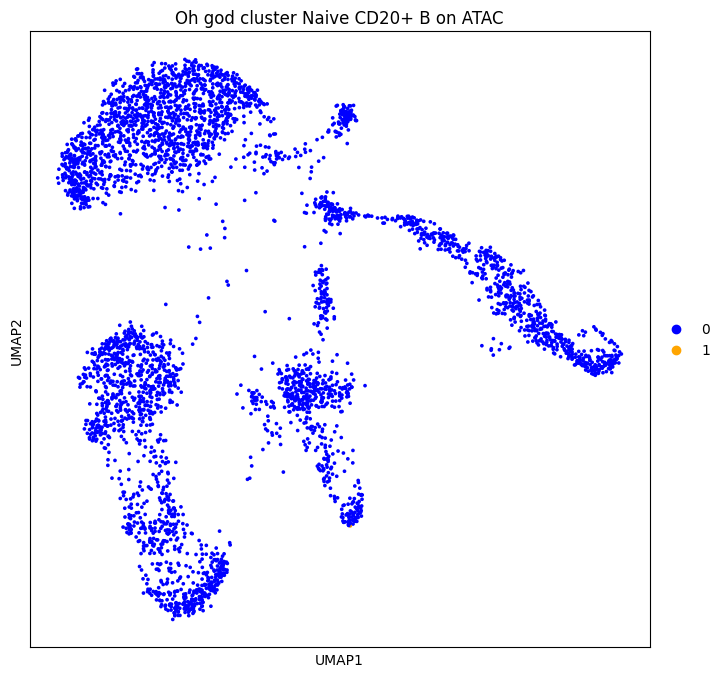

In [33]:
adata_rna_sub.obs['test'] = test_vec_atac
adata_atac_sub.obs['test'] = test_vec_atac

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ atac_clust[0] + ' on RNA')

sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ atac_clust[0] + ' on ATAC')

In [34]:
remove_mask = adata_atac_sub[~adata_atac_sub.obs['leiden_final'].isin(['Oh god'])].obs_names

In [35]:
adata_rna_sub = adata_rna_sub[remove_mask]
adata_atac_sub = adata_atac_sub[remove_mask]

Add celltype for Oh god cells, where association is clear

In [36]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    given_ct = adata_rna_sub.obs['celltype'][idx]
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    atac_ct = adata_atac_sub.obs['leiden_final'][idx]
    
    if given_ct == 'Oh god':
        if rna_ct == 'cDC2':
            # Below would be adding a label if celltype association is clear
           new_celltype_ann.append('cDC2')
#        elif atac_ct == 'ILC':
#            new_celltype_ann.append('ILC')
#        elif rna_ct == 'naive CD20+ B':
#            new_celltype_ann.append('Naive CD20+ B')
        else:
            new_celltype_ann.append('Oh god')
    else:
        new_celltype_ann.append(given_ct)

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_atac_sub.obs['celltype'] = final_ann_df

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [37]:
adata_rna_sub.obs['celltype'].value_counts()

CD14+ Mono          1308
Erythroblast         478
CD4+ T activated     446
Naive CD20+ B        289
NK                   269
CD4+ T naive         254
CD16+ Mono           209
CD8+ T               169
Normoblast           146
Lymph prog           109
pDCs                  89
Proerythroblast       85
Plasma cells          76
B1 B                  67
G/M prog              60
HSC                   50
cDC2                  34
MK/E prog             33
Transitional B        31
ILC                   18
Name: celltype, dtype: int64

### Remove unresolvable cells

Remove remaining Oh god cells

In [38]:
adata_rna_sub = adata_rna_sub[~adata_rna_sub.obs['celltype'].isin(['Oh god'])].copy()
adata_atac_sub = adata_atac_sub[~adata_atac_sub.obs['celltype'].isin(['Oh god'])].copy()

... storing 'celltype' as categorical


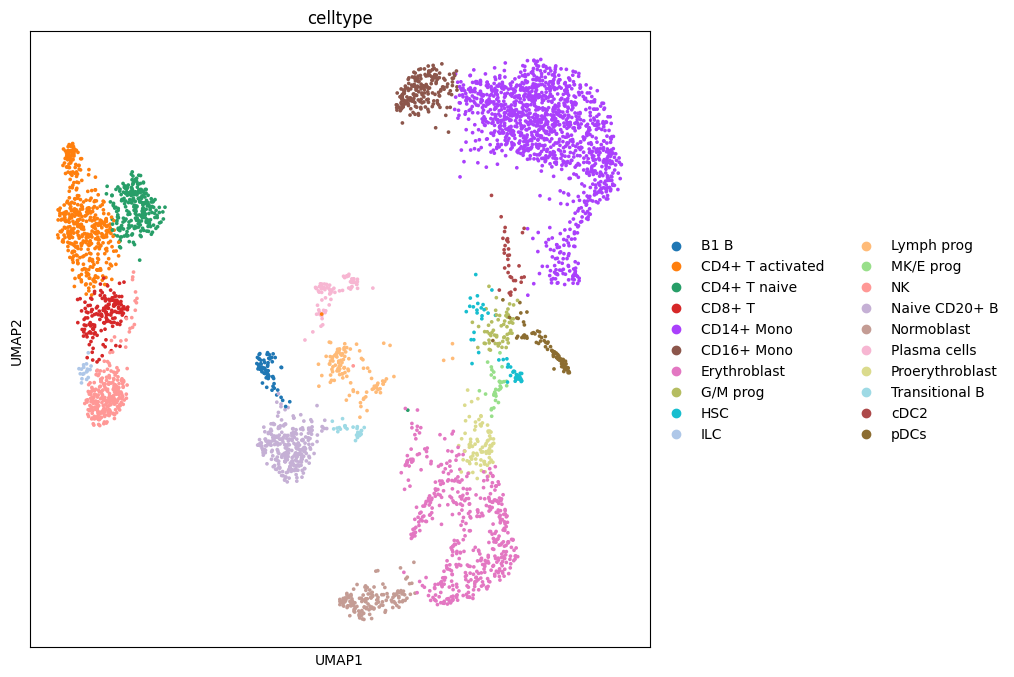

... storing 'celltype' as categorical


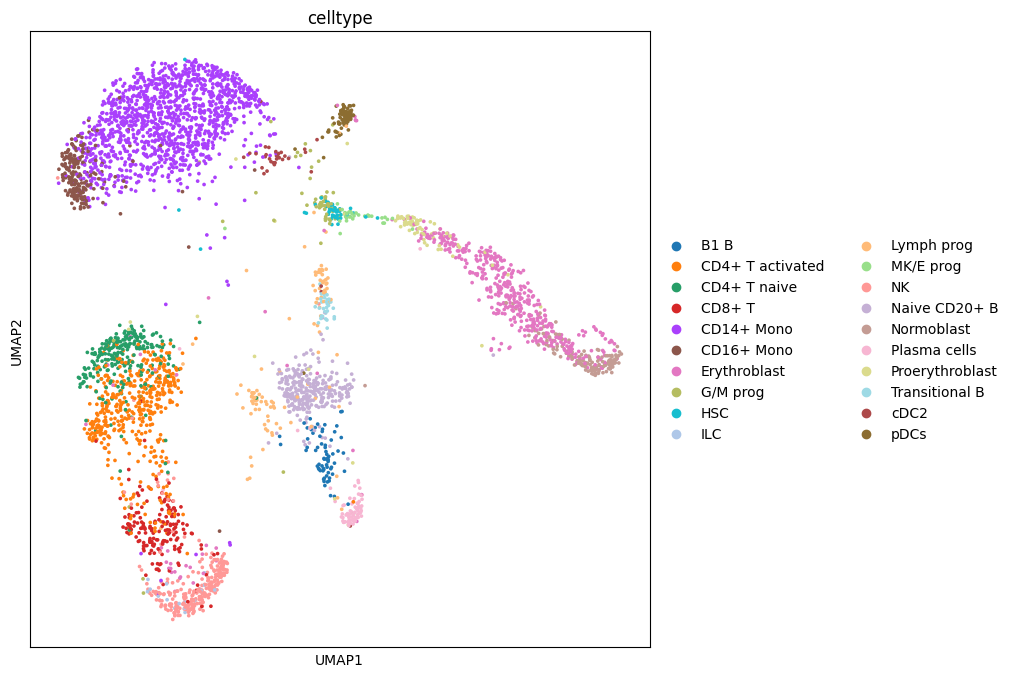

In [39]:
sc.pl.umap(adata_rna_sub, color='celltype')
sc.pl.umap(adata_atac_sub, color='celltype')

## Rename some cell types

In [40]:
rename_clust_dict = {
    'CD8+ T':'CD8+ T',
    'CD4+ T naive':'CD4+ T naive',
    'NK':'NK',
    'CD14+ Mono':'CD14+ Mono',
    'ILC':'ILC',
    'CD4+ T activated':'CD4+ T activated',
    'CD16+ Mono':'CD16+ Mono',
    'Erythroblast':'Erythroblast',
    'B1 B': 'B1 B',
    'Naive CD20+ B':'Naive CD20+ B',
    'cDC2':'cDC2',
    'MK/E prog':'MK/E prog',
    'pDCs':'pDC',
    'Normoblast':'Normoblast',
    'Transitional B':'Transitional B',
    'Proerythroblast':'Proerythroblast',
    'HSC':'HSC',
    'Lymph prog':'Lymph prog',
    'Plasma cells':'Plasma cells',
    'G/M prog':'G/M prog',
    'ID2-hi myeloid prog':'ID2-hi myeloid prog'
}

In [41]:
adata_rna_sub.rename_categories('celltype', [rename_clust_dict[ct] for ct in adata_rna_sub.obs['celltype'].cat.categories])

In [42]:
adata_atac_sub.rename_categories('celltype', [rename_clust_dict[ct] for ct in adata_atac_sub.obs['celltype'].cat.categories])

# ATAC object back to peaks

In [43]:
# Switch over peaks and gene activity
adata_atac_sub_peak = ad.AnnData(X = adata_atac_sub.obsm['peaks'],
                                 obs = adata_atac_sub.obs, 
                                 var = pd.DataFrame(index=adata_atac_sub.uns['peak_names']))

In [44]:
adata_atac_sub_peak

AnnData object with n_obs × n_vars = 4220 × 156481
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype'

In [45]:
adata_atac_sub_peak.var_names

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-183983-184830', 'chr1-191133-192055', 'chr1-267562-268456',
       'chr1-585752-586647', 'chr1-629497-630394', 'chr1-633515-634474',
       'chr1-778276-779191',
       ...
       'GL000219.1-168678-169485', 'KI270734.1-121040-121955',
       'GL000218.1-96879-97775', 'KI270721.1-2091-2979',
       'KI270726.1-27152-28034', 'KI270726.1-41476-42297',
       'KI270713.1-21434-22336', 'KI270713.1-26002-26720',
       'KI270713.1-29629-30491', 'KI270713.1-36926-37828'],
      dtype='object', length=156481)

In [46]:
adata_atac_sub_peak.obsm['lsi_full'] = adata_atac_sub.obsm['lsi_full']
adata_atac_sub_peak.obsm['lsi_red'] = adata_atac_sub.obsm['lsi_red']
adata_atac_sub_peak.obsm['umap'] = adata_atac_sub.obsm['umap']
adata_atac_sub_peak.obsm['gene_activity'] = adata_atac_sub.X
adata_atac_sub_peak.uns['gene_activity_var_names'] = [str(i) for i in adata_atac_sub.var_names]

adata_atac_sub_peak.uns['neighbors'] = adata_atac_sub.uns['neighbors']
adata_atac_sub_peak.obsp['connectivities'] = adata_atac_sub.obsp['connectivities']
adata_atac_sub_peak.obsp['distances'] = adata_atac_sub.obsp['distances']

In [47]:
adata_atac_sub_peak

AnnData object with n_obs × n_vars = 4220 × 156481
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

# Trajectories

## RNA Trajectory

In [48]:
adata_rna_sub.obs['celltype'].value_counts()

CD14+ Mono          1308
Erythroblast         478
CD4+ T activated     446
Naive CD20+ B        289
NK                   269
CD4+ T naive         254
CD16+ Mono           209
CD8+ T               169
Normoblast           146
Lymph prog           109
pDC                   89
Proerythroblast       85
Plasma cells          76
B1 B                  67
G/M prog              60
HSC                   50
cDC2                  34
MK/E prog             33
Transitional B        31
ILC                   18
Name: celltype, dtype: int64

In [49]:
adata_rna_ery = adata_rna_sub[adata_rna_sub.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast'])].copy()

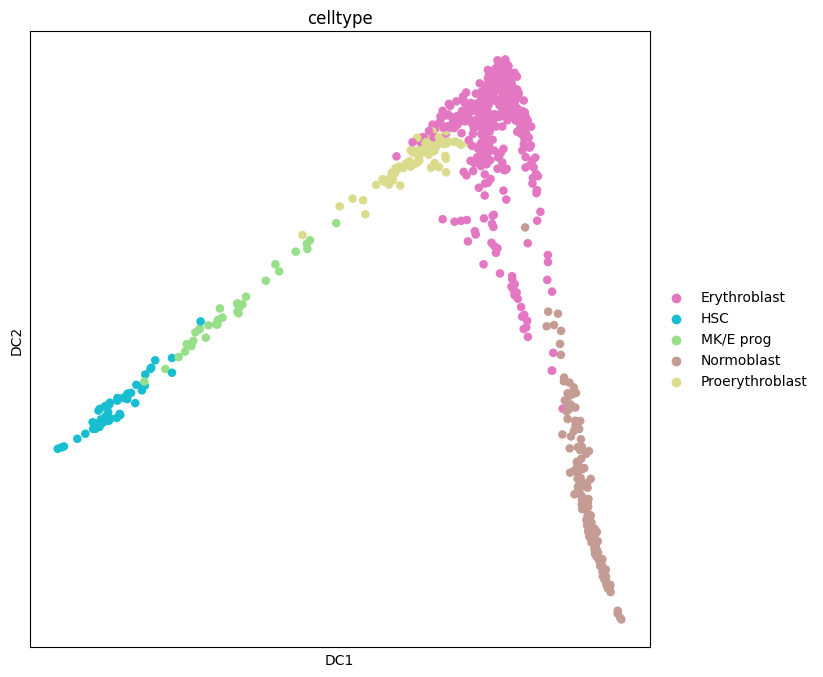

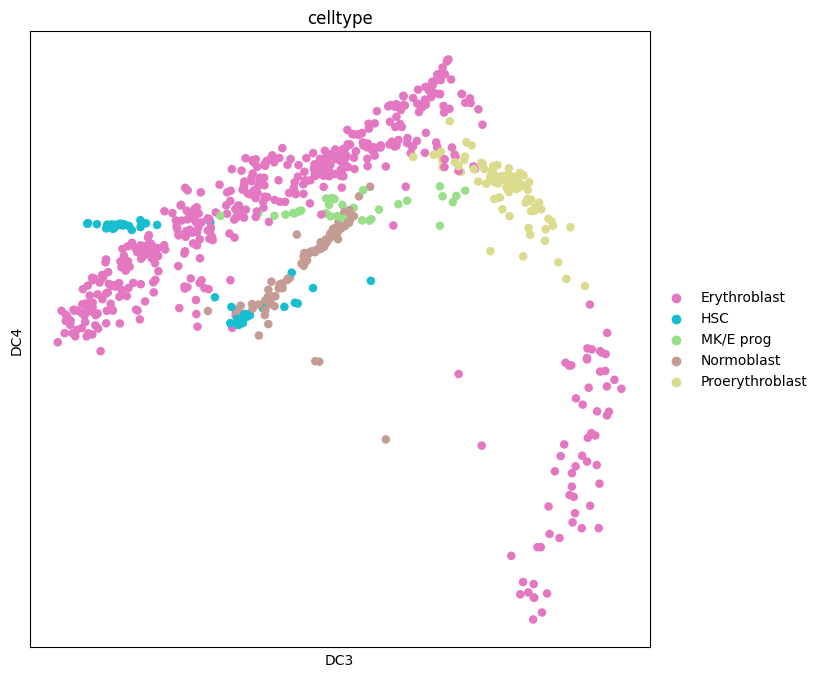

In [50]:
sc.pp.neighbors(adata_rna_ery)
sc.tl.diffmap(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='3,4', frameon=True)

In [51]:
# Get DC1 min, DC2 max cell as root (most outer stem cell like cell)
# NOTE: argmax() or argmin() often needs to be reassigned for each run

c1 = adata_rna_ery.obsm['X_diffmap'][:,1].argmin()
c2 = c1 #adata_rna_ery.obsm['X_diffmap'][:,2].argmax()

correct root cell: TGCCTGTTCTTAATGG-4


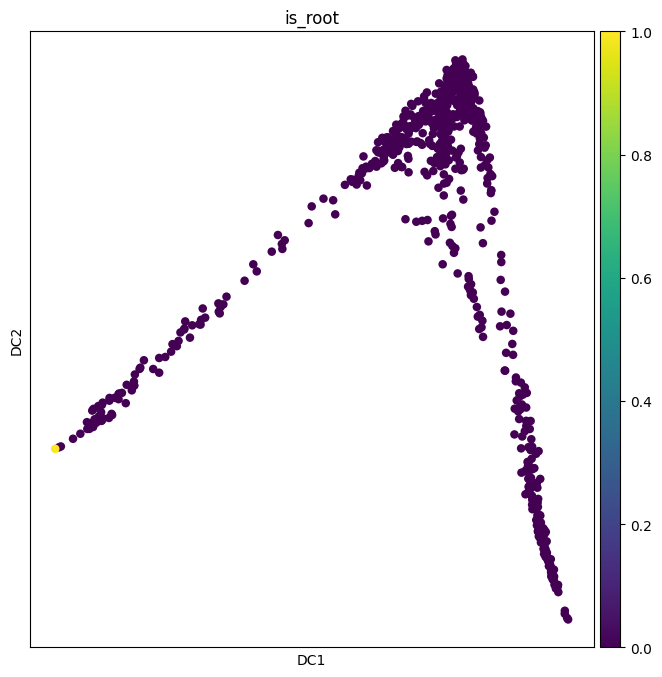

In [52]:
if c1 == c2:
    print(f'correct root cell: {adata_rna_ery.obs_names[c1]}')
    adata_rna_ery.uns['iroot'] = c1
    
    #check if correct
    adata_rna_ery.obs['is_root'] = [1 if idx==adata_rna_ery.obs_names[c1] else 0 for idx in adata_rna_ery.obs_names]
    sc.pl.diffmap(adata_rna_ery, color='is_root', components='1,2', frameon=True)
     

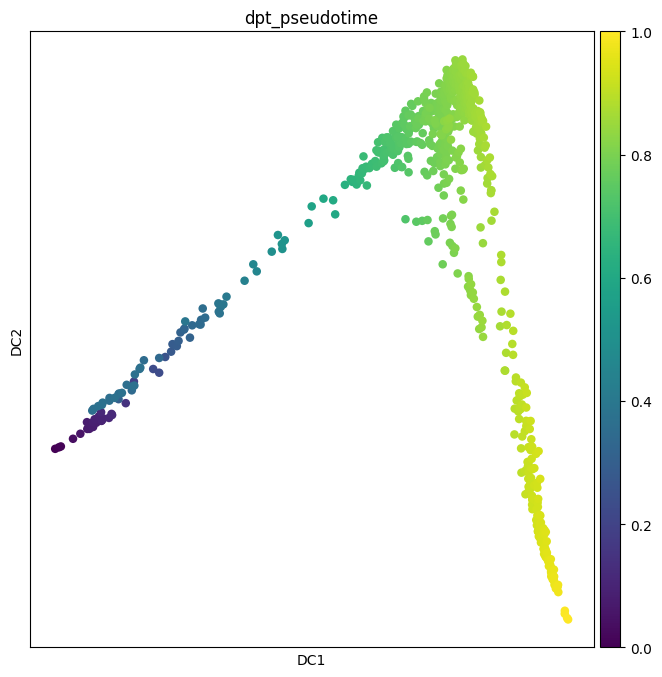

In [53]:
sc.tl.dpt(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [54]:
# Transfer back to full object
adata_rna_sub.obs['pseudotime_order_GEX'] = adata_rna_ery.obs['dpt_pseudotime']

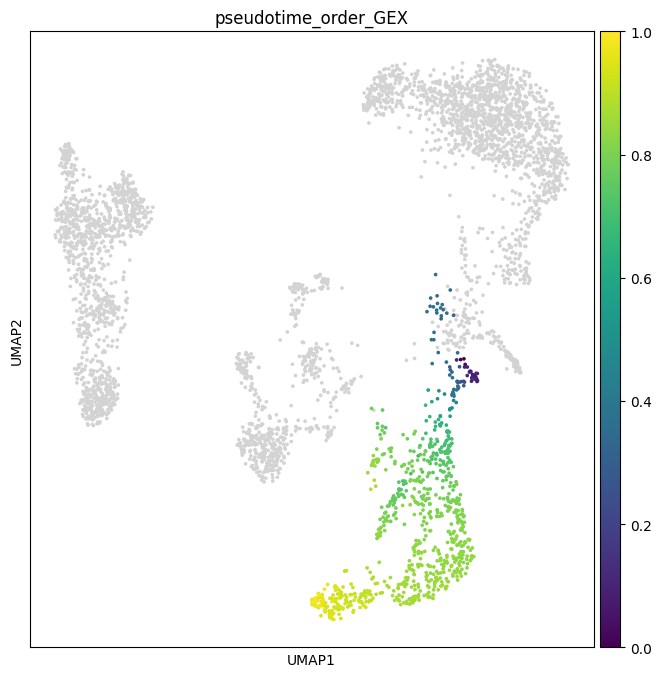

In [55]:
sc.pl.umap(adata_rna_sub, color='pseudotime_order_GEX')

## ATAC Trajectory

In [56]:
adata_atac_sub_peak.obs['celltype'].value_counts()

CD14+ Mono          1308
Erythroblast         478
CD4+ T activated     446
Naive CD20+ B        289
NK                   269
CD4+ T naive         254
CD16+ Mono           209
CD8+ T               169
Normoblast           146
Lymph prog           109
pDC                   89
Proerythroblast       85
Plasma cells          76
B1 B                  67
G/M prog              60
HSC                   50
cDC2                  34
MK/E prog             33
Transitional B        31
ILC                   18
Name: celltype, dtype: int64

In [57]:
adata_atac_ery = adata_atac_sub_peak[adata_atac_sub_peak.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast'])].copy()


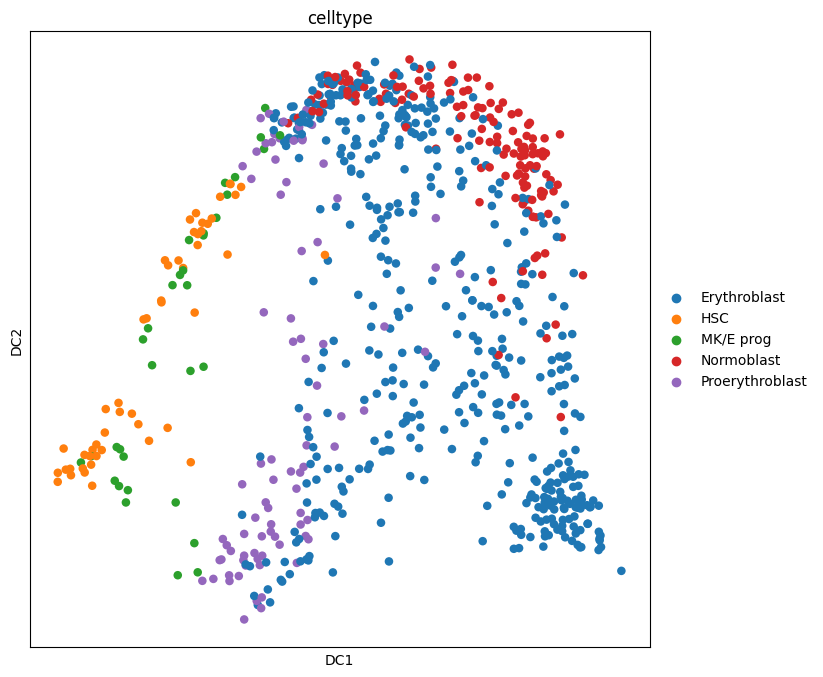

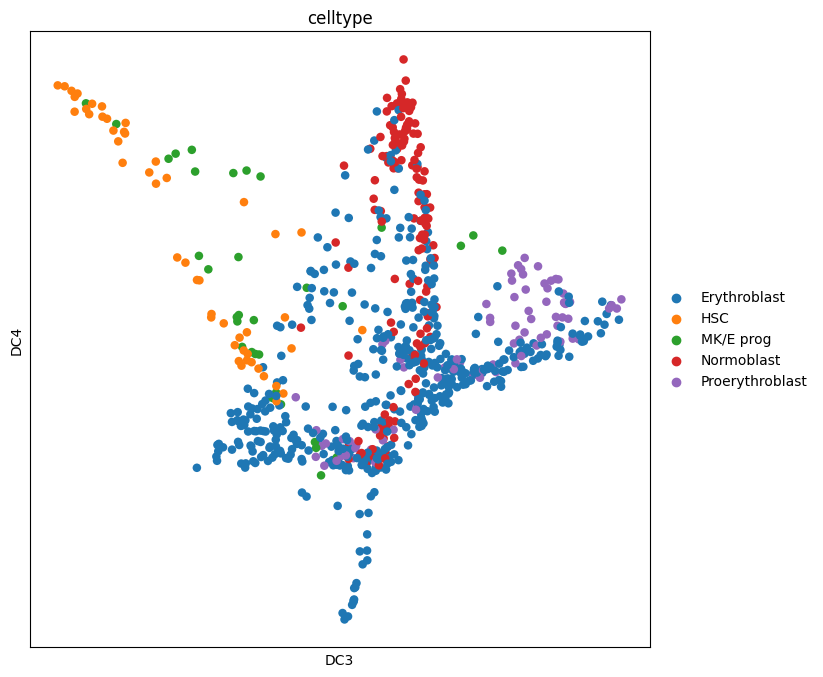

In [58]:
sc.pp.neighbors(adata_atac_ery, use_rep = 'lsi_red')
sc.tl.diffmap(adata_atac_ery)
sc.pl.diffmap(adata_atac_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_atac_ery, color='celltype', components='3,4', frameon=True)

correct root cell: TTAGGCTAGCTCATAA-4


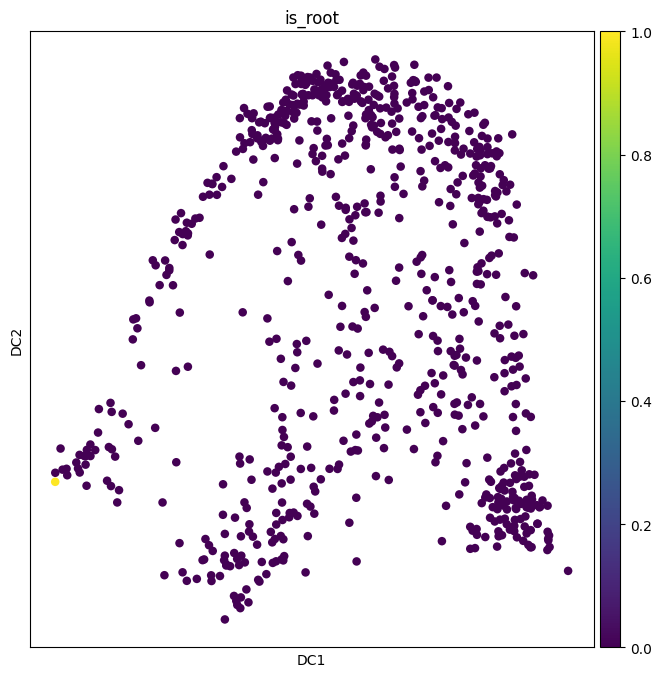

In [59]:
# Get DC1 min, DC2 max cell as root (should be the outer most stemm cell
c1 = adata_atac_ery.obsm['X_diffmap'][:,1].argmin()
c2 = c1
#c1 = adata_atac_ery.obsm['X_diffmap'][:,1].argmax()
#c2 = c1 #adata_atac_ery.obsm['X_diffmap'][:,2].argmin()

if c1 == c2:
    print(f'correct root cell: {adata_atac_ery.obs_names[c1]}')
    adata_atac_ery.uns['iroot'] = c1
    
    #check if correct
    adata_atac_ery.obs['is_root'] = [1 if idx==adata_atac_ery.obs_names[c1] else 0 for idx in adata_atac_ery.obs_names]
    sc.pl.diffmap(adata_atac_ery, color='is_root', components='1,2', frameon=True)

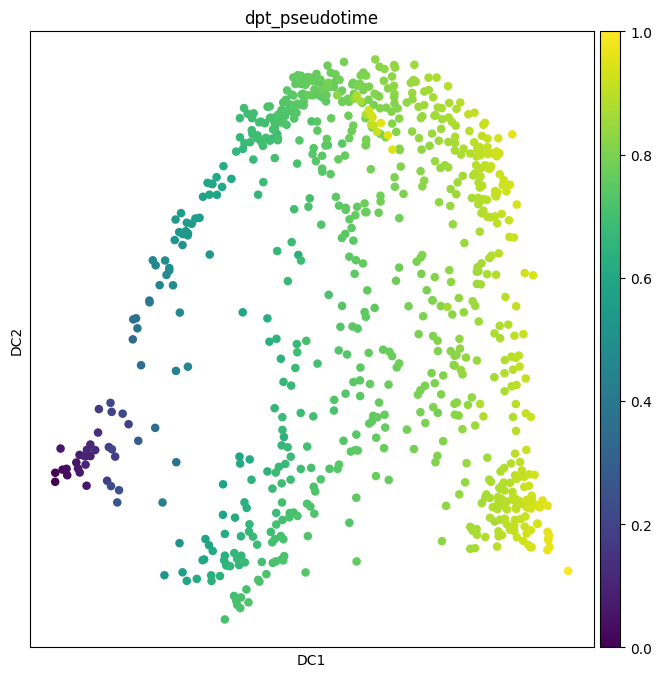

In [60]:
sc.tl.dpt(adata_atac_ery)
sc.pl.diffmap(adata_atac_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [61]:
# Transfer back to full object
adata_atac_sub_peak.obs['pseudotime_order_ATAC'] = adata_atac_ery.obs['dpt_pseudotime']

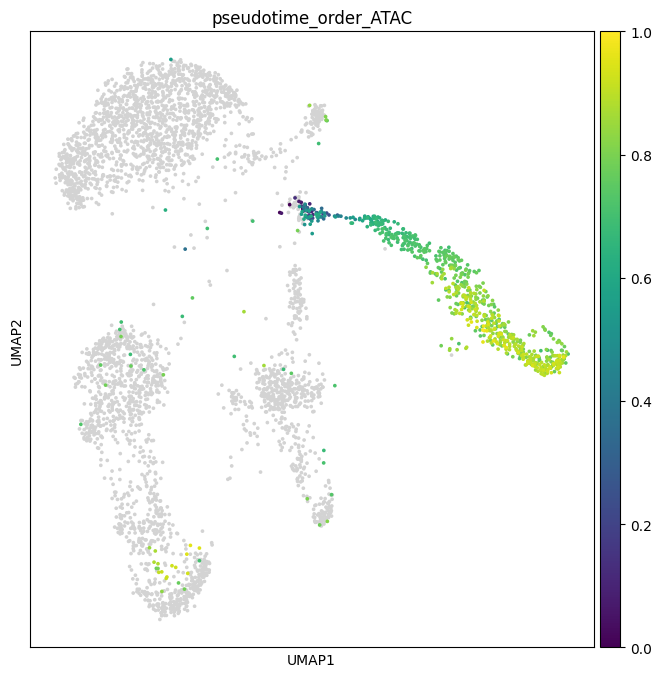

In [62]:
sc.pl.umap(adata_atac_sub_peak, color='pseudotime_order_ATAC')

## Write output

Save RNA data

In [63]:
# Check the object
adata_rna_sub

AnnData object with n_obs × n_vars = 4220 × 17431
    obs: 'sample', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_res0.5_msub3', 'leiden_res0.5_msub4', 'leiden_res0.5_bsub2', 'leiden_res0.5_epsub2', 'leiden_res0.5_5sub', 'leiden_res0.5_bsub3', 'leiden_res0.5_bsub4', 'leiden_res0.5_doubsub', 'leiden_intermediate1', 'leiden_intermediate2', 'leiden_intermediate3', 'leiden_intermediate4', 'leiden_final', 'atac_ann', 'test', 'celltype', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_5sub_colors', 'leiden_res0.5_bsub2_colors', 'leiden_res0.5_bsub3_colors', 'leiden_res0.5_bsub4_colors', 'leiden_res0.5_doubsub_colors', 'leiden_res0.5_epsub2_colors', 'leiden_res0.5_epsub_colors', 'leiden_res0.5_msub2_colors', 'leiden_res0.5_msub3_colors', 'leiden_res0.5_msub4_colors', 'leiden_res0.5_msub_colors', 'leiden_res0.5_tsub_colors', 'neighbors', 'pca', 'rg_res0.5_5sub', '

In [64]:
# Create slim rna adata
adata_rna_slim = ad.AnnData(X=adata_rna_sub.X,
                            obs=adata_rna_sub.obs[['n_genes_by_counts','pct_counts_mt',
                                                  'n_counts','n_genes','size_factors','phase',
                                                  'leiden_final','atac_ann','celltype','pseudotime_order_GEX']],
                           var=adata_rna_sub.var)

adata_rna_slim.obs = adata_rna_slim.obs.rename(columns={'celltype':'cell_type'})
adata_rna_slim.var['feature_types'] = 'GEX'

adata_rna_slim.uns = adata_rna_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_rna_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_rna_slim.uns[col])

adata_rna_slim.obsm = adata_rna_sub.obsm
adata_rna_slim.varm = adata_rna_sub.varm
adata_rna_slim.obsp = adata_rna_sub.obsp
adata_rna_slim.layers['counts'] = adata_rna_sub.layers['counts']

In [65]:
adata_rna_slim

AnnData object with n_obs × n_vars = 4220 × 17431
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'rg_res0.5_5sub', 'rg_res0.5_bsub2', 'rg_res0.5_bsub3', 'rg_res0.5_bsub4', 'rg_res0.5_doubsub', 'rg_res0.5_epsub2', 'rg_res0.5_msub3', 'rg_res0.5_msub4', 'rg_res0.5_tsub', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [66]:
# Save
adata_rna_slim.write_h5ad('project/proc_data/s2d1/donor1_rna_processed.h5ad')

... storing 'feature_types' as categorical


Save ATAC data

In [67]:
# Check the object
adata_atac_sub_peak

AnnData object with n_obs × n_vars = 4220 × 156481
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype', 'pseudotime_order_ATAC'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

In [68]:
adata_atac.var_names

Index(['OR4F5', 'OR4F29', 'OR4F16', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'PERM1', 'HES4', 'ISG15',
       ...
       'BPY2', 'DAZ1', 'DAZ2', 'PRYP3', 'CDY1B', 'BPY2B', 'DAZ3', 'DAZ4',
       'BPY2C', 'CDY1'],
      dtype='object', length=19039)

In [69]:
# Create slim atac adata
adata_atac_slim = ad.AnnData(X=adata_atac_sub_peak.X,
                            obs=adata_atac_sub_peak.obs[['nCount_peaks', 'atac_fragments',
                                                   'reads_in_peaks_frac', 'blacklist_fraction',
                                                   'nucleosome_signal', 'leiden_final', 'rna_ann',
                                                   'celltype', 'pseudotime_order_ATAC']],
                            var=pd.DataFrame(index=adata_atac_sub_peak.var_names))

adata_atac_slim.obs = adata_atac_slim.obs.rename(columns={'celltype':'cell_type'})
adata_atac_slim.var['feature_types'] = 'ATAC'

adata_atac_slim.uns = adata_atac_sub_peak.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_atac_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_atac_slim.uns[col])

adata_atac_slim.obsm = adata_atac_sub_peak.obsm
adata_atac_slim.obsp = adata_atac_sub_peak.obsp

In [70]:
adata_atac_slim

AnnData object with n_obs × n_vars = 4220 × 156481
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'rna_ann', 'cell_type', 'pseudotime_order_ATAC'
    var: 'feature_types'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

In [71]:
adata_atac_slim.write_h5ad('project/proc_data/s2d1/donor1_atac_processed.h5ad')

... storing 'feature_types' as categorical


### Uploading the final h5ad output to the s3 bucket

Use aws s3 ls to figure out the file directory, then use

aws s3 cp file_name_to_upload file_path_to_upload

For example, we used

aws s3 cp project/proc_data/s2d1/donor1_atac.h5ad s3://openproblems-bio/neurips2021/site2/production/donor01.lot3054455/atac/processed/